## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality.

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [5]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [6]:
import os
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

False

In [7]:
if IN_COLAB and os.getcwd() == "/content":
    # Clone the entire repo.
    !git clone https://github.com/superkisa/natural-language-processing.git -b 23f_msai --single-branch
    %cd natural-language-processing
    !ls

    !pip install torchtext==0.6.0 subword_nmt nltk
    sys.path.append("/content/natural-language-processing/homeworks/hw01_neural_machine_translation")

In [8]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = './homeworks/hw01_neural_machine_translation/data/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc -O homeworks/hw01_neural_machine_translation/data/data.txt
    # path_do_data = './data.txt'

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.data import Field, BucketIterator

# import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
tokenizer_W = WordPunctTokenizer()


def tokenize(x, tokenizer=tokenizer_W):
    x = x.lower()
    x = x.replace(",", "")  # remove commas
    x = x.replace("'s", "")  # remove "'s"
    x = x.replace("'", "")  # remove apostrophes
    return tokenizer.tokenize(x)

In [12]:
SRC = Field(
    tokenize=tokenize,
    init_token="<sos>",
    eos_token="<eos>",
    lower=True,
)

TRG = Field(
    tokenize=tokenize,
    init_token="<sos>",
    eos_token="<eos>",
    lower=True,
)

dataset = torchtext.data.TabularDataset(
    path=path_do_data, format="tsv", fields=[("trg", TRG), ("src", SRC)]
)

In [13]:
dataset.examples[0]

In [14]:
from itertools import zip_longest


tuple(zip_longest(dataset.examples[0].src, dataset.examples[0].trg))

(('отель', 'cordelia'),
 ('cordelia', 'hotel'),
 ('расположен', 'is'),
 ('в', 'situated'),
 ('тбилиси', 'in'),
 ('в', 'tbilisi'),
 ('3', 'a'),
 ('минутах', '3'),
 ('ходьбы', '-'),
 ('от', 'minute'),
 ('свято', 'walk'),
 ('-', 'away'),
 ('троицкого', 'from'),
 ('собора', 'saint'),
 ('.', 'trinity'),
 (None, 'church'),
 (None, '.'))

In [15]:
train_data, valid_data, test_data = dataset.split(
    split_ratio=[0.8, 0.15, 0.05], # type: ignore
)

In [16]:
print(f"Number of training examples: {len(train_data.examples)}")  # type: ignore
print(f"Number of validation examples: {len(valid_data.examples)}")  # type: ignore
print(f"Number of testing examples: {len(test_data.examples)}")  # type: ignore

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [17]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [18]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9277
Unique tokens in target (en) vocabulary: 6718


## experiment1


In [19]:
from gensim.models import Word2Vec

In [20]:
russian_sentences = [vars(example)["src"] for example in dataset.examples]
english_sentences = [vars(example)["trg"] for example in dataset.examples]

In [21]:
english_model = Word2Vec(english_sentences, vector_size=256, window=3, min_count=1, workers=8)
russian_model = Word2Vec(russian_sentences, vector_size=256, window=3, min_count=1, workers=8)

english_model.save("./homeworks/hw01_neural_machine_translation/models/english_model")
russian_model.save("./homeworks/hw01_neural_machine_translation/models/russian_model")

In [22]:
english_model.wv["king"]

array([ 3.34841162e-02, -3.78065743e-02,  5.16786836e-02,  3.44258212e-02,
        1.57055065e-01, -9.65010375e-03, -5.00261299e-02, -6.51955605e-02,
       -4.37343493e-02,  1.25530869e-01, -1.05809234e-02,  1.00422315e-01,
       -7.90929422e-02, -1.55093953e-01,  1.30738644e-02,  9.96186733e-02,
        5.84779605e-02,  2.22440921e-02, -4.29774933e-02,  2.44122684e-01,
        7.72000551e-02,  3.40040686e-04, -1.13671564e-01, -1.65545642e-01,
       -2.25835308e-01,  1.86431035e-02, -8.87511298e-02,  2.74836998e-02,
       -1.75939977e-01, -6.24125972e-02,  3.04859579e-02,  1.03486650e-01,
       -7.56123960e-02, -8.41574743e-02, -5.78395575e-02,  2.31747031e-01,
        1.64364606e-01, -1.63236544e-01,  1.56057954e-01, -6.12050965e-02,
       -1.87724773e-02,  2.25047588e-01, -1.43975109e-01, -1.47885010e-01,
        1.43543363e-01, -1.50127485e-01, -2.23463960e-03, -2.97084693e-02,
        8.32090825e-02,  6.44445047e-02,  2.81755608e-02,  6.73080161e-02,
        2.65164282e-02,  

In [21]:
russian_model.wv["город"]

array([ 0.2767559 , -0.5807589 ,  0.39435902,  0.41316146,  0.67613846,
       -0.03727266,  0.22882041, -0.0705124 ,  0.60452855,  1.2622632 ,
       -0.31476504,  0.5234098 , -0.46685538, -0.7685919 , -0.08855101,
        0.5342506 ,  0.5461749 ,  0.06933086, -0.13270493,  0.36667058,
        0.7515794 ,  0.71428037,  0.3121768 , -0.12607875, -0.6630366 ,
        0.5434451 , -0.15998599,  0.7111316 , -0.2212415 , -0.8528515 ,
       -0.0526377 ,  0.37803593,  0.07914951,  0.28810883, -0.5405651 ,
        0.5195915 ,  0.50736654, -0.78058845, -0.29305562, -0.9891441 ,
       -0.22815076,  0.3638698 , -0.19262363, -0.51678336, -0.12929298,
        0.6330007 ,  0.56129885,  0.16173172, -0.09317743, -0.5956281 ,
       -0.76306826,  0.2895572 , -0.25902426,  0.6523626 ,  0.23678853,
       -0.00983779,  0.5006967 ,  0.8251933 ,  0.29330823,  0.06370146,
        0.4534455 ,  0.38184506,  0.3598398 ,  1.0414932 ,  0.9472373 ,
       -0.18848103,  0.5007621 ,  0.27848518,  0.09490388,  0.67

In [32]:
english_model.wv.key_to_index

{'.': 0,
 'a': 1,
 'the': 2,
 'and': 3,
 'is': 4,
 '-': 5,
 'with': 6,
 'from': 7,
 'in': 8,
 'km': 9,
 'free': 10,
 'of': 11,
 'are': 12,
 'at': 13,
 'can': 14,
 'away': 15,
 'hotel': 16,
 'offers': 17,
 'property': 18,
 'rooms': 19,
 'tv': 20,
 'private': 21,
 'on': 22,
 'airport': 23,
 'available': 24,
 'located': 25,
 'minute': 26,
 'an': 27,
 'guests': 28,
 'also': 29,
 'to': 30,
 'area': 31,
 'bathroom': 32,
 'metres': 33,
 'drive': 34,
 'room': 35,
 'parking': 36,
 'you': 37,
 'facilities': 38,
 '’': 39,
 'site': 40,
 '5': 41,
 'centre': 42,
 'air': 43,
 'restaurant': 44,
 'features': 45,
 'this': 46,
 'wifi': 47,
 'there': 48,
 'walk': 49,
 'it': 50,
 'or': 51,
 'all': 52,
 'kitchen': 53,
 'be': 54,
 'flat': 55,
 '2': 56,
 'screen': 57,
 'shower': 58,
 'equipped': 59,
 'for': 60,
 'apartment': 61,
 'breakfast': 62,
 '1': 63,
 'each': 64,
 'fi': 65,
 'wi': 66,
 'as': 67,
 'beach': 68,
 'pool': 69,
 'station': 70,
 'garden': 71,
 'has': 72,
 'accommodation': 73,
 'terrace': 74,
 

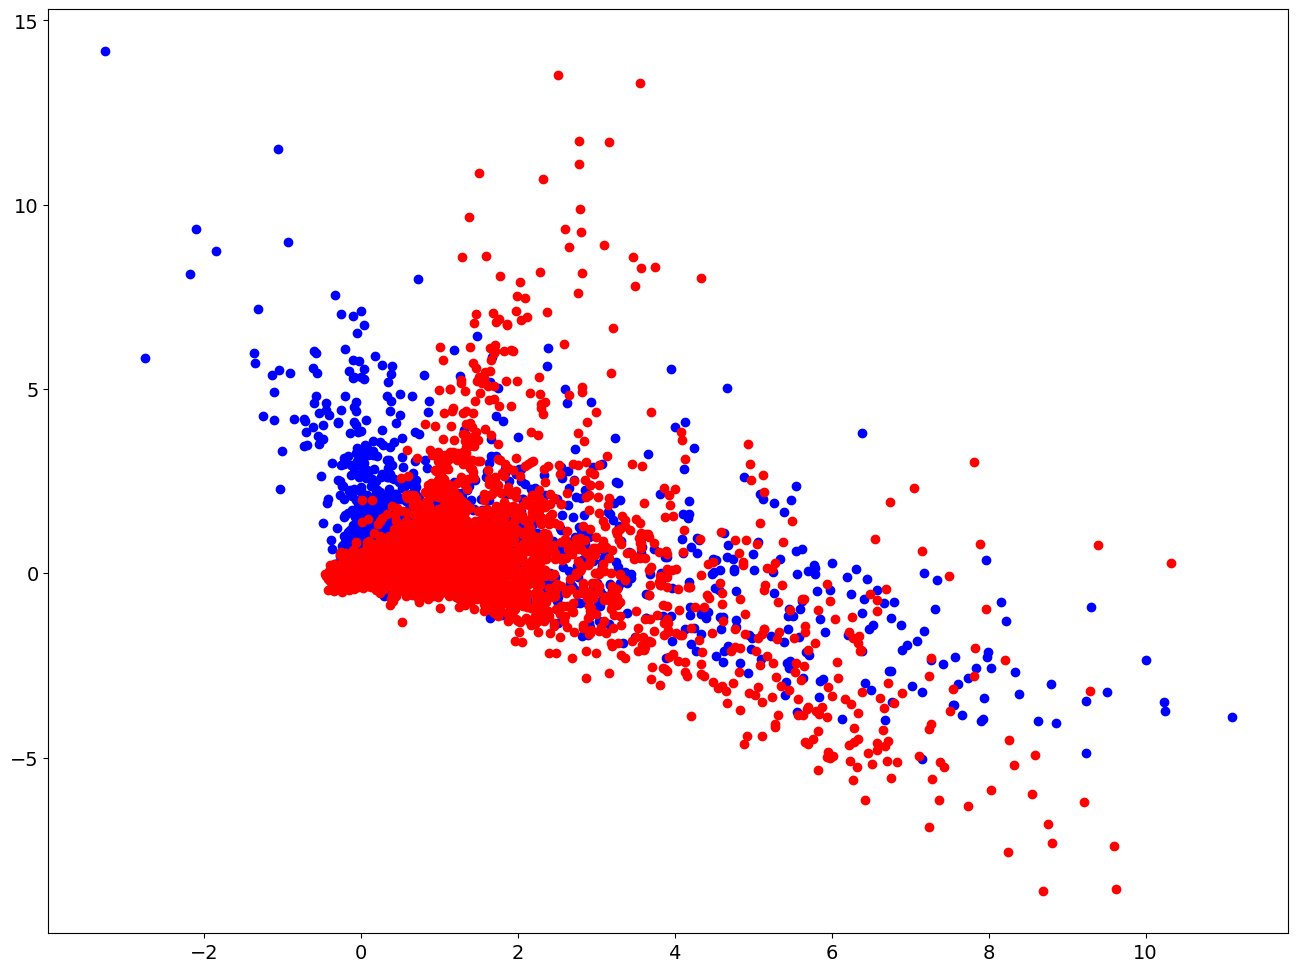

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get all word vectors
word_vectors_eng = english_model.wv.vectors
word_vectors_rus = russian_model.wv.vectors

# Perform PCA
pca = PCA(n_components=2)
principal_components_eng = pca.fit_transform(word_vectors_eng)
principal_components_rus = pca.fit_transform(word_vectors_rus)

# Plot the results
plt.scatter(principal_components_eng[:, 0], principal_components_eng[:, 1], color="b")
plt.scatter(principal_components_rus[:, 0], principal_components_rus[:, 1], color="r")
plt.show()

Here are tokens from original (RU) corpus:

In [ ]:
# SRC.vocab.itos[::1000]

['<unk>',
 'современными',
 'совершать',
 'идеальным',
 'эйр',
 'христа',
 'ilvretta',
 'трабзон',
 'двухэтажные',
 'тегель']

And from target (EN) corpus:

In [ ]:
# TRG.vocab.itos[::1000]

['<unk>', 'order', 'iem', 'trampoline', 'adi', 'auvergne', 'rapid']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'kitchen', 'i', 'equipped', 'with', 'a', 'dihwaher', 'and', 'an', 'oven', 'a', 'well', 'a', 'a', 'coffee', 'machine', 'and', 'a', 'kettle', '.'], 'src': ['кухня', 'оснащена', 'посудомоечной', 'машиной', 'духовкой', 'кофемашиной', 'и', 'чайником', '.']}


Let's check the length distributions:

Length distribution in Train data


(array([4.8300e+02, 8.9930e+03, 1.1929e+04, 7.4980e+03, 5.9020e+03,
        2.8790e+03, 1.1200e+03, 7.4300e+02, 2.5000e+02, 1.0300e+02,
        6.3000e+01, 2.5000e+01, 7.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ,
        52.7, 57.4, 62.1, 66.8, 71.5, 76.2, 80.9, 85.6, 90.3, 95. ]),
 <BarContainer object of 20 artists>)

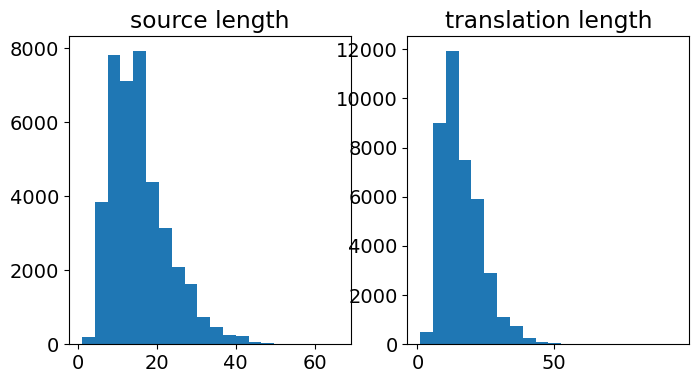

In [54]:
src_length = map(len, [vars(x)["src"] for x in train_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in train_data.examples])

print("Length distribution in Train data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

Length distribution in Test data


(array([1.000e+00, 2.650e+02, 1.000e+03, 1.402e+03, 1.314e+03, 1.129e+03,
        8.350e+02, 6.030e+02, 3.590e+02, 2.310e+02, 1.420e+02, 1.040e+02,
        4.700e+01, 2.600e+01, 2.000e+01, 1.000e+01, 6.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31., 34., 37.,
        40., 43., 46., 49., 52., 55., 58., 61.]),
 <BarContainer object of 20 artists>)

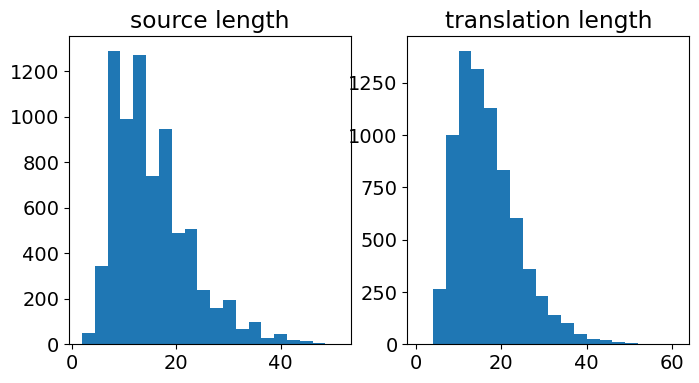

In [55]:
src_length = map(len, [vars(x)["src"] for x in test_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in test_data.examples])

print("Length distribution in Test data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [70]:
def _len_sort_key(x):
    return len(x.src)


BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key,
)

In [69]:
# for x in train_iterator:
#     break
# print(x)
# print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 49x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 44x128 (GPU 0)]
torch.Size([44, 128]) torch.Size([49, 128])


In [79]:
import numpy as np

english_vectors_np = np.array(
    [english_model.wv[word] for word in english_model.wv.key_to_index]
)
russian_vectors_np = np.array(
    [russian_model.wv[word] for word in russian_model.wv.key_to_index]
)

english_vectors = torch.from_numpy(english_vectors_np).to(device)
russian_vectors = torch.from_numpy(russian_vectors_np).to(device)

In [24]:
class EncoderW2V(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, model, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.model = model

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.dropout = nn.Dropout(p=dropout)

        self.embedding = english_vectors

    def forward(self, src):
        embedded = self.model.mv[src].to(self.device)
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.rnn(embedded)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.out = nn.Linear(in_features=hid_dim, out_features=len(russian_vectors))

        self.dropout = nn.Dropout(p=dropout)

        self.embedding = russian_vectors

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding[input]).to("cuda")
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert (
            encoder.hid_dim == decoder.hid_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = len(russian_vectors)

        # tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)

        # first input to the decoder is the <sos> tokens
        input = trg[0, :]

        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = trg[t] if teacher_force else top1

        return outputs

In [26]:
len(SRC.vocab)

9219

In [25]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderW2V(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

TypeError: EncoderW2V.__init__() missing 1 required positional argument: 'dropout'

In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn): LSTM(9260, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (rnn): LSTM(6265, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=44684, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 61,025,932 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi["<pad>"]
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def train(
    model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None
):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        # trg = [(trg sent len - 1) * batch size]
        # output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label="train loss")
            ax[0].set_xlabel("Batch")
            ax[0].set_title("Train loss")
            if train_history is not None:
                ax[1].plot(train_history, label="general train history")
                ax[1].set_xlabel("Epoch")
            if valid_history is not None:
                ax[1].plot(valid_history, label="general valid history")
            plt.legend()

            plt.show()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0)  # turn off teacher forcing

            # trg = [trg sent len, batch size]
            # output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            # trg = [(trg sent len - 1) * batch size]
            # output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float("inf")

In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(
        model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history
    )
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}")

RuntimeError: ignored

__Let's take a look at our network quality__:

In [ ]:
del utils

In [ ]:
import utils
import imp

imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1, 2]:
    src = batch.src[:, idx : idx + 1]
    trg = batch.trg[:, idx : idx + 1]
    generate_translation(src, trg, model, TRG.vocab)

AttributeError: ignored

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)  # turn off teacher forcing

        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend(
            [get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T]
        )

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:07,  8.13it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

13.505832172804677

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set.
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points